In [30]:
! pip install kneed

In [ ]:
! pip install tslearn

In [151]:

import math
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import operator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from functools import reduce
from scipy import stats
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from typing import List, Callable

from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

### Подготовка данных
- определяем временные отрезки для проведения кластеризации данных и непосредственно теста

In [2]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [3]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [4]:
# введем переменные с датами
# пусть предэкспериментальный период будет равен 50 дням (чуть больше теста)
end_of_30 = datetime.datetime.strptime('2022-04-07', "%Y-%m-%d")
start_of_30 = end_of_30 + datetime.timedelta(days=-50)

start_dt = start_of_30.strftime("%Y-%m-%d")
end_dt = end_of_30.strftime("%Y-%m-%d")
end_of_test_dt = '2022-05-19'
start_dt, end_dt, end_of_test_dt

('2022-02-16', '2022-04-07', '2022-05-19')

In [5]:
# данные экспериментального периода
experiment = df[
    (df['dt'] > end_dt)&(df['dt'] <= end_of_test_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
experiment.shape

(11042, 14)

In [6]:
# данные предэкспериментального периода
pre_exp = df[
    (df['dt'] >= start_dt)&(df['dt'] < end_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
pre_exp.shape

(13140, 14)

In [7]:
pre_exp[pre_exp["CityName"]=="Казань"].head(3)

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
140171,2022-02-16T00:00:00.000Z,Казань,web,пицца,100899.4931,113463.81,24328.389720,232.0,130.0,124.0,29.087296,434.911608,2022-02,2022-02-16
143192,2022-02-17T00:00:00.000Z,Казань,web,пицца,110966.3100,126714.60,28893.071037,255.0,140.0,134.0,12.555224,435.162000,2022-02,2022-02-17
146230,2022-02-18T00:00:00.000Z,Казань,web,пицца,155305.9480,182940.36,39929.625037,371.0,202.0,193.0,25.779657,418.614415,2022-02,2022-02-18


In [8]:
assert pre_exp['CityName'].nunique() == df['CityName'].nunique() # нет новых городов на предэкспериментальном периоде

In [9]:
assert pre_exp['CityName'].nunique() == experiment['CityName'].nunique() # нет новых городов на экспериментальном периоде

In [10]:
pre_exp[pre_exp["CityName"]=="Самара"].shape

(50, 14)

### Сравнение методов кластеризации данных
- KMeans агрегированных данных
- KMeans временных рядов
- KNN (на всех данных)
- векторное сравнение

#### Кластеризация агрегированных данных

In [11]:
# соберем датасет для кластеризации
pivot_for_cluster = pre_exp.groupby('CityName').agg(
    {
        'rto': 'sum',
        'cost': 'sum',
        'qty': 'sum',
        'clients_qty': 'sum'
    }
).sort_values('rto', ascending=False).reset_index()
pivot_for_cluster['rto'] = pivot_for_cluster['rto'].astype('int')
pivot_for_cluster['cost'] = pivot_for_cluster['cost'].astype('int')
# уберем из кластеризации Москву и Спб, так как кластеризация выделяет их в отдельный кластер, мы этого не хотим.
pivot_for_cluster = pivot_for_cluster[~pivot_for_cluster['CityName'].isin(['Москва', 'Санкт-Петербург'])].reset_index(drop=True)
pivot_for_cluster.head(10)

,CityName,rto,cost,qty,clients_qty
0,Самара,16026737,4050406,34875.0,17166.0
1,Екатеринбург,13663217,3337150,29147.0,14582.0
2,Челябинск,10433277,2794639,23451.0,12220.0
3,Краснодар,8609991,2047640,16589.0,8872.0
4,Нижний Новгород,8479303,2120621,17312.0,8927.0
5,Ульяновск,8051164,2109697,19359.0,9450.0
6,Новосибирск,7755947,1989265,15631.0,7355.0
7,Тюмень,7740492,1849008,15715.0,8240.0
8,Ростов-на-Дону,7499478,1955061,16254.0,7378.0
9,Казань,6658360,1735571,14797.0,7471.0


Проведем кластеризацию городов на предэкспериментальном периоде

In [12]:
scaled_df = StandardScaler().fit_transform(pivot_for_cluster[['rto', 'cost', 'qty', 'clients_qty']])

In [13]:
print(scaled_df[:5])

[[7.16860849 7.08454191 7.29296118 7.09628649]
 [5.99473992 5.69576411 5.96858447 5.90551881]
 [4.39055419 4.6394432  4.65160651 4.81705392]
 [3.48499887 3.18496455 3.06503651 3.27421715]
 [3.42009121 3.32706555 3.23220207 3.29956244]]


In [14]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 20,
  "random_state": 42,
}

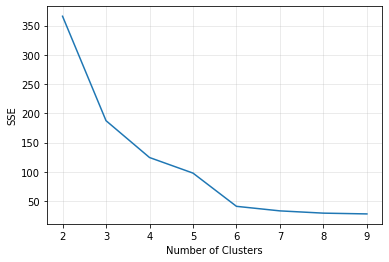

In [15]:
# определяем оптимальное кол-во кластеров
plt.style.use("bmh")

sse = []
start_clusters_nums = 2
end_clusters_nums = 10
for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)
plt.plot(range(start_clusters_nums, end_clusters_nums), sse)
plt.xticks(range(start_clusters_nums, end_clusters_nums))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(alpha=0.3)
plt.show()

крутой излом начинается с 6-го кластера, проверим с помощью встроенного метода

In [16]:
kl = KneeLocator(
    range(start_clusters_nums, end_clusters_nums), sse, curve="convex", direction="decreasing"
)
kl.elbow

6

In [17]:
# также можно проверить итератирвно с помощью silhouette_score
silhouette_coefficients = []

for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)

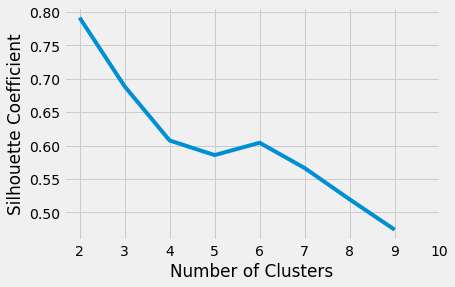

In [18]:
plt.style.use("fivethirtyeight")
plt.plot(range(start_clusters_nums, end_clusters_nums), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Вывод: 6 кластеров - оптимальное значение для выбранных данных

In [19]:
kmeans = KMeans(init="random", n_clusters=kl.elbow, n_init=10, random_state=42)
kmeans.fit(scaled_df)
kmeans.labels_[:5]

array([4, 4, 4, 4, 4])

In [20]:
pivot_for_cluster['cluster'] = kmeans.labels_

In [21]:
pivot_for_cluster['cluster'].value_counts()

0    109
3     63
1     42
2     24
5     15
4      9
Name: cluster, dtype: int64

In [22]:
# посмотрим какие кластера получились
pd.options.display.max_colwidth = 1000
pivot_for_cluster.groupby(['cluster']).agg({'CityName': lambda x: list(x)})

,CityName
cluster,
0,"[Апатиты, Воркута, Сергиев Посад, Красное Село, Солнечногорск, Звенигород, Верхняя Пышма, Выборг, Кингисепп, Нахабино, Наро-Фоминск, Нижнекамск, Егорьевск, Усинск, Шушары, Кириши, Анапа, Орск, Горно-Алтайск, Лыткарино, Ступино, Старая Купавна, Нягань, Салават, Можайск, Югорск, Ленинск-Кузнецкий, Стерлитамак, Ковров, Златоуст, Внуково, Копейск, Аксай Россия, Шатура, Александров, Прокопьевск, Геленджик, Чайковский, Рыбинск, Павловский Посад, Новочебоксарск, Кубинка, Октябрьский, Кронштадт, Шлиссельбург, Губкинский, Муром, Кстово, Ликино-Дулево, Батайск, Невинномысск, Махачкала, Пятигорск, Камышин, Муравленко, Металлострой, Тосно, Усолье-Сибирское, Владикавказ, Сызрань, Вязьма, Электроугли, Азов, Канск, Новоуральск, Майкоп, Стрежевой, Ессентуки, Губкин, Бугульма, Лянтор, Воткинск, Хотьково, Урай, Корсаков, Лабытнанги, Голицыно, Каменск-Шахтинский, Волхов, Сарапул, Заречный, Ржев, Котлас, Краснокамск, Полевской, Конаково, Грозный, Белогорск, Абинск, Минеральные Воды, Переславль-Залесск..."
1,"[Красногорск, Балашиха, Люберцы, Сочи, Долгопрудный, Мурманск, Магадан, Одинцово, Курган, Реутов, Череповец, Щелково, Тамбов, Нефтеюганск, Белгород, Псков, Астрахань, Петергоф, Таганрог, Домодедово, Мурино, Всеволожск, Брянск, Бердск, Нижний Тагил, Железнодорожный, Парголово, Барнаул, Вологда, Магнитогорск, Тула, Коммунарка, Архангельск, Ухта, Братск, Ханты-Мансийск, Великий Новгород, Курск, Саранск, Кемерово, Новокузнецк, Орел]"
2,"[Иркутск, Нижневартовск, Хабаровск, Красноярск, Калининград, Мытищи, Смоленск, Южно-Сахалинск, Пенза, Новый Уренгой, Благовещенск, Королев, Чита, Химки, Рязань, Щербинка, Якутск, Новороссийск, Ставрополь, Зеленоград, Владивосток, Чебоксары, Петрозаводск, Комсомольск-на-Амуре]"
3,"[Норильск, Салехард, Ноябрьск, Надым, Дубна, Ногинск, Йошкар-Ола, Лобня, Березники, Обнинск, Серпухов, Подольск, Колпино, Пушкино, Троицк, Липецк, Рассказовка, Волжский, Орехово-Зуево, Абакан, Калуга, Кудрово, Набережные Челны, Гатчина, Московский, Северск, Дмитров, Фрязино, Северодвинск, Дзержинск, Иваново, Уссурийск, Видное, Электросталь, Балаково, Тобольск, Петропавловск-Камчатский, Коломна, Сертолово, Владимир, Клин, Энгельс, Ивантеевка, Пушкин, Сосновый Бор, Славянка, Улан-Удэ, Чехов, Жуковский, Воскресенск, Дедовск, Альметьевск, Когалым, Раменское, Апрелевка, Каменск-Уральский, Находка, Истра, Саров, Новокуйбышевск, Никольское, Миасс, Старый Оскол]"
4,"[Самара, Екатеринбург, Челябинск, Краснодар, Нижний Новгород, Ульяновск, Новосибирск, Тюмень, Ростов-на-Дону]"
5,"[Казань, Саратов, Воронеж, Тольятти, Омск, Сургут, Уфа, Томск, Оренбург, Киров, Тверь, Волгоград, Сыктывкар, Пермь, Ижевск]"


In [23]:
test_towns = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

In [24]:
pivot_for_cluster[pivot_for_cluster['CityName'].isin(test_towns)]

,CityName,rto,cost,qty,clients_qty,cluster
15,Уфа,4831874,1310332,11202.0,5689.0,5
32,Пенза,3164901,884061,7114.0,3790.0,2
72,Нижний Тагил,1655917,461095,3914.0,2176.0,1
89,Курск,1451251,382650,2992.0,1876.0,1
151,Новокуйбышевск,749163,200506,1795.0,982.0,3
170,Орск,633995,175330,1338.0,765.0,0


Чтобы посмотреть не только кластер города, но и найти окрестность соседних городов, посчитаем дисперсию метрики для каждого города в рамках его кластера и отсортируем по ее убыванию

In [25]:
# считаем стандартное отклонение для каждого города
total_revenue = pre_exp.groupby(['CityName', 'dt']).agg({'rto': 'sum'}).reset_index()
pivot_disp = total_revenue.groupby('CityName').agg({'rto': 'std'}).sort_values('rto', ascending=False).reset_index()
pivot_disp['rto'] = pivot_disp['rto'].astype('int')
pivot_disp.rename(columns={'rto': 'rto_std'}, inplace=True)
pivot_disp.head(2)

,CityName,rto_std
0,Москва,792806
1,Санкт-Петербург,372616


In [26]:
pivot = pivot_for_cluster.merge(pivot_disp, how='left', on=['CityName'])
pivot.head()

,CityName,rto,cost,qty,clients_qty,cluster,rto_std
0,Самара,16026737,4050406,34875.0,17166.0,4,172555
1,Екатеринбург,13663217,3337150,29147.0,14582.0,4,125546
2,Челябинск,10433277,2794639,23451.0,12220.0,4,92818
3,Краснодар,8609991,2047640,16589.0,8872.0,4,69393
4,Нижний Новгород,8479303,2120621,17312.0,8927.0,4,79321


Отбор в группы

In [27]:
def foo(diff_with_down, diff_with_up, dif):
  if diff_with_down > diff_with_up:
    return dif
  else:
    return -dif

In [28]:
# сдвигаем наблюдения и рассчитываем разницу между значениями верхнего соседа и нижнего
pivot = pivot.sort_values(['cluster', 'rto_std']).reset_index(drop=True)
pivot['down_shift_1'] = pivot['rto_std'].shift(1, fill_value=0)
pivot['up_shift_1'] = pivot['rto_std'].shift(-1, fill_value=0)
pivot['down_shift_2'] = pivot['rto_std'].shift(2, fill_value=0)
pivot['up_shift_2'] = pivot['rto_std'].shift(-2, fill_value=0)
pivot['diff_with_down_1'] = abs(pivot['rto_std'] - pivot['down_shift_1'])
pivot['diff_with_up_1'] = abs(pivot['rto_std'] - pivot['up_shift_1'])
pivot['diff_with_down_2'] = abs(pivot['rto_std'] - pivot['down_shift_2'])
pivot['diff_with_up_2'] = abs(pivot['rto_std'] - pivot['up_shift_2'])


pivot['neighbour_1'] = pivot.apply(lambda x: foo(x['diff_with_down_1'], x['diff_with_up_1'], 1), axis=1)
pivot['neighbour_2'] = pivot.apply(lambda x: foo(x['diff_with_down_2'], x['diff_with_up_2'], 2), axis=1)
pivot['neighbour_index_1'] = pivot.index + pivot['neighbour_1']
pivot['neighbour_index_2'] = pivot.index + pivot['neighbour_2']

In [29]:
test_ids = set(pivot[pivot["CityName"].isin(test_towns)].index)
test_ids

{96, 112, 128, 166, 177, 251}

In [30]:
for i in test_ids:
    display(pivot.iloc[i, 0])
    display(pivot.iloc[i-5:i+5, :])

'Орск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
91,Нижнекамск,673649,169485,1487.0,823.0,0,7260,7117,7308,7077,7364,143,48,183,104,1,2,92,93
92,Чайковский,481278,143503,1292.0,673.0,0,7308,7260,7364,7117,7427,48,56,191,119,-1,2,91,94
93,Звенигород,734895,178307,1390.0,789.0,0,7364,7308,7427,7260,7441,56,63,104,77,-1,2,92,95
94,Кириши,640479,160338,1367.0,794.0,0,7427,7364,7441,7308,7526,63,14,119,99,1,2,95,96
95,Новочебоксарск,477523,113768,1081.0,572.0,0,7441,7427,7526,7364,7585,14,85,77,144,-1,-2,94,93
96,Орск,633995,175330,1338.0,765.0,0,7526,7441,7585,7427,7722,85,59,99,196,1,-2,97,94
97,Красное Село,739189,187966,1581.0,745.0,0,7585,7526,7722,7441,7819,59,137,144,234,-1,-2,96,95
98,Сергиев Посад,740455,176198,1398.0,871.0,0,7722,7585,7819,7526,7855,137,97,196,133,1,2,99,100
99,Аксай Россия,504374,139709,1036.0,574.0,0,7819,7722,7855,7585,7877,97,36,234,58,1,2,100,101
100,Рыбинск,480334,139309,1064.0,621.0,0,7855,7819,7877,7722,7884,36,22,133,29,1,2,101,102


'Нижний Тагил'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
123,Тула,1536199,432331,3164.0,1643.0,1,16400,16067,16486,15868,16799,333,86,532,399,1,2,124,125
124,Мурино,1736173,461451,3814.0,2118.0,1,16486,16400,16799,16067,16867,86,313,419,381,-1,2,123,126
125,Магадан,1948308,484730,3141.0,1776.0,1,16799,16486,16867,16400,16930,313,68,399,131,1,2,126,127
126,Сочи,2225768,485703,4044.0,1977.0,1,16867,16799,16930,16486,17347,68,63,381,480,1,-2,127,124
127,Одинцово,1941514,482307,3839.0,1913.0,1,16930,16867,17347,16799,17884,63,417,131,954,-1,-2,126,125
128,Нижний Тагил,1655917,461095,3914.0,2176.0,1,17347,16930,17884,16867,18161,417,537,480,814,-1,-2,127,126
129,Псков,1797451,465971,3913.0,2069.0,1,17884,17347,18161,16930,18345,537,277,954,461,1,2,130,131
130,Домодедово,1765331,448214,3651.0,1924.0,1,18161,17884,18345,17347,18351,277,184,814,190,1,2,131,132
131,Вологда,1577340,457851,3431.0,2057.0,1,18345,18161,18351,17884,18362,184,6,461,17,1,2,132,133
132,Курган,1930505,497291,4429.0,2658.0,1,18351,18345,18362,18161,18447,6,11,190,96,-1,2,131,134


'Пенза'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
161,Чита,2960019,808293,6124.0,3293.0,2,28483,26383,28655,26224,29464,2100,172,2259,981,1,2,162,163
162,Смоленск,3197983,923385,6781.0,4032.0,2,28655,28483,29464,26383,29589,172,809,2272,934,-1,2,161,164
163,Южно-Сахалинск,3184324,689624,5079.0,2917.0,2,29464,28655,29589,28483,29732,809,125,981,268,1,2,164,165
164,Рязань,2856337,826338,6032.0,3412.0,2,29589,29464,29732,28655,31834,125,143,934,2245,-1,-2,163,162
165,Новый Уренгой,3050173,831581,5102.0,2863.0,2,29732,29589,31834,29464,32555,143,2102,268,2823,-1,-2,164,163
166,Пенза,3164901,884061,7114.0,3790.0,2,31834,29732,32555,29589,33602,2102,721,2245,1768,1,2,167,168
167,Королев,2983282,735835,5668.0,2930.0,2,32555,31834,33602,29732,34892,721,1047,2823,2337,-1,2,166,169
168,Мытищи,3265289,821919,6366.0,3189.0,2,33602,32555,34892,31834,35103,1047,1290,1768,1501,-1,2,167,170
169,Иркутск,3698891,929802,7612.0,4176.0,2,34892,33602,35103,32555,35706,1290,211,2337,814,1,2,170,171
170,Нижневартовск,3658561,888569,7387.0,3746.0,2,35103,34892,35706,33602,35787,211,603,1501,684,-1,2,169,172


'Курск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
107,Верхняя Пышма,718728,176617,1530.0,810.0,0,8965,8465,11016,8458,12252,500,2051,507,3287,-1,-2,106,105
108,Солнечногорск,735966,183480,1520.0,801.0,0,11016,8965,12252,8465,12904,2051,1236,2551,1888,1,2,109,110
109,Кемерово,1444723,426836,3389.0,1648.0,1,12252,11016,12904,8965,13154,1236,652,3287,902,1,2,110,111
110,Новокузнецк,1410821,426346,3246.0,1522.0,1,12904,12252,13154,11016,14154,652,250,1888,1250,1,2,111,112
111,Братск,1472076,425047,3518.0,1843.0,1,13154,12904,14154,12252,14293,250,1000,902,1139,-1,-2,110,109
112,Курск,1451251,382650,2992.0,1876.0,1,14154,13154,14293,12904,14613,1000,139,1250,459,1,2,113,114
113,Ханты-Мансийск,1464048,361440,2829.0,1685.0,1,14293,14154,14613,13154,14666,139,320,1139,373,-1,2,112,115
114,Архангельск,1525949,396567,3122.0,1828.0,1,14613,14293,14666,14154,14848,320,53,459,235,1,2,115,116
115,Орел,1409548,413836,3173.0,1864.0,1,14666,14613,14848,14293,15121,53,182,373,455,-1,-2,114,113
116,Саранск,1444989,423437,3203.0,1955.0,1,14848,14666,15121,14613,15312,182,273,235,464,-1,-2,115,114


'Новокуйбышевск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
172,Щербинка,2736714,724064,5330.0,2605.0,2,35787,35706,41355,35103,46287,81,5568,684,10500,-1,-2,171,170
173,Хабаровск,3503442,924800,7110.0,3584.0,2,41355,35787,46287,35706,7675,5568,4932,5649,33680,1,-2,174,171
174,Красноярск,3475013,792707,6957.0,3597.0,2,46287,41355,7675,35787,7819,4932,38612,10500,38468,-1,-2,173,172
175,Никольское,738615,216313,1813.0,823.0,3,7675,46287,7819,41355,7894,38612,144,33680,219,1,2,176,177
176,Альметьевск,875715,218401,2056.0,1210.0,3,7819,7675,7894,46287,8463,144,75,38468,644,1,2,177,178
177,Новокуйбышевск,749163,200506,1795.0,982.0,3,7894,7819,8463,7675,8951,75,569,219,1057,-1,-2,176,175
178,Саров,754853,193441,1575.0,951.0,3,8463,7894,8951,7819,9080,569,488,644,617,1,2,179,180
179,Старый Оскол,706405,186685,1596.0,903.0,3,8951,8463,9080,7894,9137,488,129,1057,186,1,2,180,181
180,Каменск-Уральский,814548,225726,1711.0,970.0,3,9080,8951,9137,8463,9140,129,57,617,60,1,2,181,182
181,Улан-Удэ,916603,252004,1959.0,1083.0,3,9137,9080,9140,8951,9233,57,3,186,96,1,2,182,183


'Уфа'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
246,Самара,16026737,4050406,34875.0,17166.0,4,172555,125546,34884,116479,38195,47009,137671,56076,134360,-1,-2,245,244
247,Ижевск,3720325,1045851,9187.0,4669.0,5,34884,172555,38195,125546,39636,137671,3311,90662,4752,1,2,248,249
248,Волгоград,4196677,1180064,9291.0,4704.0,5,38195,34884,39636,172555,39825,3311,1441,134360,1630,1,2,249,250
249,Пермь,3902818,993393,8897.0,4507.0,5,39636,38195,39825,34884,42653,1441,189,4752,3017,1,2,250,251
250,Оренбург,4444748,1223156,9529.0,5350.0,5,39825,39636,42653,38195,42940,189,2828,1630,3115,-1,-2,249,248
251,Уфа,4831874,1310332,11202.0,5689.0,5,42653,39825,42940,39636,45331,2828,287,3017,2678,1,2,252,253
252,Сыктывкар,4028433,1030741,8804.0,5060.0,5,42940,42653,45331,39825,46926,287,2391,3115,3986,-1,-2,251,250
253,Томск,4497402,1242852,9758.0,5004.0,5,45331,42940,46926,42653,49218,2391,1595,2678,3887,1,-2,254,251
254,Тверь,4372394,1211770,9132.0,4337.0,5,46926,45331,49218,42940,49302,1595,2292,3986,2376,-1,2,253,256
255,Киров,4385318,1152053,9954.0,5354.0,5,49218,46926,49302,45331,54387,2292,84,3887,5169,1,-2,256,253


#### Кластеризация временных рядов

##### tslearn

In [50]:
pre_exp.head()

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
139295,2022-02-16T00:00:00.000Z,Абакан,web,пицца,19586.21,21464.73,5098.530568,40.0,19.0,18.0,35.345056,489.655250,2022-02,2022-02-16
139307,2022-02-16T00:00:00.000Z,Абинск,web,пицца,7909.93,8600.16,2051.308277,18.0,10.0,10.0,30.992893,439.440556,2022-02,2022-02-16
139319,2022-02-16T00:00:00.000Z,Азов,web,пицца,2019.43,2210.31,550.452191,4.0,2.0,2.0,32.554409,504.857500,2022-02,2022-02-16
139329,2022-02-16T00:00:00.000Z,Аксай Россия,web,пицца,2657.27,2746.59,572.321473,7.0,5.0,5.0,23.590850,379.610000,2022-02,2022-02-16
139340,2022-02-16T00:00:00.000Z,Александров,web,пицца,7047.18,8009.76,1653.638279,19.0,9.0,8.0,35.216210,370.904211,2022-02,2022-02-16


In [49]:
city_names = set(pre_exp["CityName"])
len(city_names)

264

In [69]:
metric_name = "rto"

series_data = []
for city in city_names:
    t = pre_exp[pre_exp["CityName"]==city][["dt", metric_name]]
    t.set_index("dt",inplace=True)
    t.sort_index(inplace=True)
    series_data.append(t[:42])

In [70]:
len(series_data), set([len(i) for i in series_data])

(264, {42})

In [72]:
for i in range(len(series_data)):
    scaler = MinMaxScaler()
    series_data[i] = MinMaxScaler().fit_transform(series_data[i])
    series_data[i]= series_data[i].reshape(len(series_data[i]))

In [85]:
for i in range(len(series_data)):
    series_data[i]= series_data[i].reshape(-1, 1)

In [73]:
print("max: "+str(max(series_data[0]))+"\tmin: "+str(min(series_data[0])))
print(series_data[0][:5])

max: 1.0	min: 0.0
[0.26835197 0.46240101 0.64574153 0.6026459  0.48489953]


In [ ]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=1)
X[0]

In [ ]:
np.array(series_data)

In [ ]:
X_train

In [ ]:
cluster_count = 10

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(np.array(X_train))

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

##### sklearn

In [31]:
pre_exp[pre_exp["CityName"]=="Казань"].head(3)

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
140171,2022-02-16T00:00:00.000Z,Казань,web,пицца,100899.4931,113463.81,24328.389720,232.0,130.0,124.0,29.087296,434.911608,2022-02,2022-02-16
143192,2022-02-17T00:00:00.000Z,Казань,web,пицца,110966.3100,126714.60,28893.071037,255.0,140.0,134.0,12.555224,435.162000,2022-02,2022-02-17
146230,2022-02-18T00:00:00.000Z,Казань,web,пицца,155305.9480,182940.36,39929.625037,371.0,202.0,193.0,25.779657,418.614415,2022-02,2022-02-18


In [32]:
sk_pre_exp = pre_exp[["dt", "CityName", "rto"]]
sk_pre_exp = sk_pre_exp[~sk_pre_exp["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [33]:
sk_pre_exp[sk_pre_exp["CityName"]=="Грозный"].head(3)

,dt,CityName,rto
139877,2022-02-16,Грозный,5739.37
142893,2022-02-17,Грозный,4381.58
145928,2022-02-18,Грозный,11523.96


In [34]:
sk_pre_exp_pivot = sk_pre_exp.pivot_table(values="rto", columns="dt", index="CityName")

In [35]:
cols = list(sk_pre_exp_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = sk_pre_exp_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [36]:
sk_pre_exp_pivot.head(2)

dt,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,...,2022-03-28,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06
CityName,,,,,,,,,,,,,,,,,,,,,
Абакан,19586.21,18898.39,39685.9169,36909.3494,17044.37,16987.25,33169.7744,75072.3400,21026.0981,24951.92,...,8034.88,11377.59,23384.1426,26833.31,22498.8659,42699.9727,22577.751,9579.50,9905.5719,13988.688
Абинск,7909.93,5728.66,13400.5900,4543.4200,4512.48,4030.53,5633.4600,12477.5308,3547.3900,4382.77,...,1983.73,4026.96,1967.0700,3546.20,3765.4099,3204.6700,2591.820,4144.77,1378.0200,902.020


In [50]:
"Москва" in sk_pre_exp_pivot.index, "Санкт-Петербург" in sk_pre_exp_pivot.index

(False, False)

In [37]:
sk_pre_exp_pivot_fill_zero = sk_pre_exp_pivot.fillna(0)

In [38]:
scaled_data = StandardScaler().fit_transform(sk_pre_exp_pivot_fill_zero)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

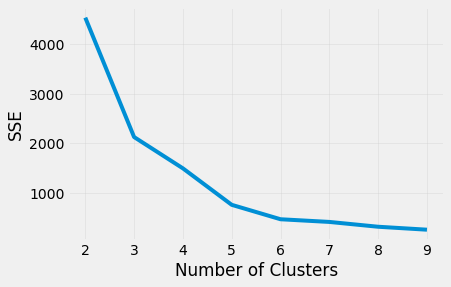

In [39]:
# определяем оптимальное кол-во кластеров
sse = []
start_clusters_nums = 2
end_clusters_nums = 10
for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_data)
    sse.append(kmeans.inertia_)
plt.plot(range(start_clusters_nums, end_clusters_nums), sse)
plt.xticks(range(start_clusters_nums, end_clusters_nums))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(alpha=0.3)
plt.show()

In [40]:
kl = KneeLocator(
    range(start_clusters_nums, end_clusters_nums), sse, curve="convex", direction="decreasing"
)
kl.elbow

5

In [45]:
# также можно проверить итератирвно с помощью silhouette_score
silhouette_coefficients = []

for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_data)
    score = silhouette_score(pca_data, kmeans.labels_)
    silhouette_coefficients.append(score)

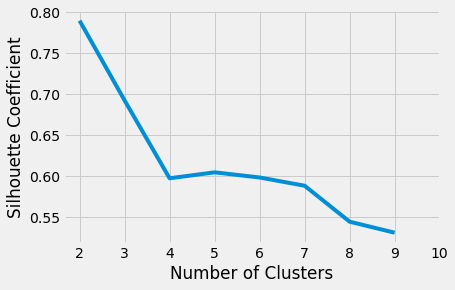

In [46]:
plt.style.use("fivethirtyeight")
plt.plot(range(start_clusters_nums, end_clusters_nums), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [41]:
kmeans = KMeans(init="random", n_clusters=6, n_init=10, random_state=42) # kl.elbow
kmeans.fit(pca_data)
kmeans.labels_[:5]

array([0, 3, 3, 3, 3])

In [42]:
sk_pre_exp_pivot_fill_zero["cluster"] = kmeans.labels_

In [43]:
sk_pre_exp_pivot_fill_zero.reset_index().head(2)

dt,CityName,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,...,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06,cluster
0,Абакан,19586.21,18898.39,39685.9169,36909.3494,17044.37,16987.25,33169.7744,75072.3400,21026.0981,...,11377.59,23384.1426,26833.31,22498.8659,42699.9727,22577.751,9579.50,9905.5719,13988.688,0
1,Абинск,7909.93,5728.66,13400.5900,4543.4200,4512.48,4030.53,5633.4600,12477.5308,3547.3900,...,4026.96,1967.0700,3546.20,3765.4099,3204.6700,2591.820,4144.77,1378.0200,902.020,3


In [44]:
pd.options.display.max_colwidth = 100000
t = sk_pre_exp_pivot_fill_zero.reset_index().groupby(['cluster']).agg({'CityName': lambda x: list(x)})
t

,CityName
cluster,
0,"[Абакан, Архангельск, Астрахань, Балашиха, Барнаул, Белгород, Бердск, Березники, Братск, Брянск, Великий Новгород, Владивосток, Волжский, Вологда, Всеволожск, Гатчина, Дмитров, Долгопрудный, Домодедово, Дубна, Железнодорожный, Зеленоград, Йошкар-Ола, Калуга, Кемерово, Колпино, Коммунарка, Комсомольск-на-Амуре, Красногорск, Кудрово, Курган, Курск, Липецк, Лобня, Люберцы, Магадан, Магнитогорск, Московский, Мурино, Мурманск, Набережные Челны, Надым, Нефтеюганск, Нижний Тагил, Новокузнецк, Новороссийск, Ногинск, Норильск, Ноябрьск, Обнинск, Одинцово, Орел, Орехово-Зуево, Парголово, Петергоф, Петрозаводск, Подольск, Псков, Пушкино, Рассказовка, Реутов, Салехард, Саранск, Северск, Серпухов, Сочи, Ставрополь, Таганрог, Тамбов, Троицк, Тула, Ухта, Фрязино, Ханты-Мансийск, Чебоксары, Череповец, Щелково, Щербинка, Якутск]"
1,"[Екатеринбург, Самара, Челябинск]"
2,"[Казань, Краснодар, Нижний Новгород, Новосибирск, Ростов-на-Дону, Саратов, Тюмень, Ульяновск]"
3,"[Абинск, Азов, Аксай Россия, Александров, Альметьевск, Анапа, Апатиты, Апрелевка, Арзамас, Балаково, Балтийск, Батайск, Белогорск, Бугульма, Бузулук, Верхняя Пышма, Видное, Владикавказ, Владимир, Внуково, Волхов, Воркута, Воскресенск, Воткинск, Выборг, Вышний Волочек, Вязьма, Геленджик, Глазов, Голицыно, Горно-Алтайск, Горячий Ключ, Грозный, Губкин, Губкинский, Дедовск, Дзержинск, Димитровград, Егорьевск, Елабуга, Ессентуки, Жуковский, Заречный, Звенигород, Златоуст, Иваново, Ивантеевка, Истра, Каменск-Уральский, Каменск-Шахтинский, Камышин, Канск, Кингисепп, Кириши, Клин, Ковров, Когалым, Коломна, Конаково, Копейск, Корсаков, Котлас, Красное Село, Краснокамск, Кронштадт, Кропоткин, Крымск, Кстово, Кубинка, Куйбышев, Лабытнанги, Лангепас, Лениногорск, Ленинск-Кузнецкий, Ликино-Дулево, Луга, Лыткарино, Лянтор, Майкоп, Махачкала, Металлострой, Миасс, Минеральные Воды, Можайск, Муравленко, Муром, Наро-Фоминск, Нахабино, Находка, Невинномысск, Нефтекамск, Нижнекамск, Никольское, Новокуйбышевск, Новоуральск, Новочебоксарск, Нягань, Октябрьский, Орск, Павловский Посад, ...]"
4,"[Благовещенск, Волгоград, Воронеж, Ижевск, Иркутск, Калининград, Киров, Королев, Красноярск, Мытищи, Нижневартовск, Новый Уренгой, Омск, Оренбург, Пенза, Пермь, Рязань, Смоленск, Сургут, Сыктывкар, Тверь, Тольятти, Томск, Уфа, Хабаровск, Химки, Чита, Южно-Сахалинск]"


In [517]:
"Ухта" in t.iloc[0, 0], "Саранск" in t.iloc[0, 0], "Курск" in t.iloc[0, 0],  "Нижний Тагил" in t.iloc[0, 0], 

(True, True, True, True)

In [522]:
"Выборг" in t.iloc[0, 0], "Саров" in t.iloc[0, 0], "Новокуйбышевск" in t.iloc[0, 0], 

(True, True, True)

In [527]:
"Орск" in t.iloc[0, 0], "Ковров" in t.iloc[0, 0], "Копейск" in t.iloc[0, 0], 

(True, True, True)

#### KNN

In [51]:
# оставляем города, включая мск и спб, кроме тех, где есть пропуски в данных
test_wo_denied_ = [i for i in set(pre_exp["CityName"]) if i not in wrong_cities]

In [52]:
knn_pre_exp = pre_exp[["dt", "CityName", "rto"]]
knn_pre_exp_clean = knn_pre_exp[knn_pre_exp["CityName"].isin(test_wo_denied_)]

In [53]:
knn_pre_exp_clean.head()

,dt,CityName,rto
139295,2022-02-16,Абакан,19586.21
139307,2022-02-16,Абинск,7909.93
139319,2022-02-16,Азов,2019.43
139329,2022-02-16,Аксай Россия,2657.27
139340,2022-02-16,Александров,7047.18


In [54]:
scaled_data = StandardScaler().fit_transform(knn_pre_exp_clean[["rto"]])
knn_pre_exp_clean["scaled_rto"] = scaled_data

<ipython-input-54-49b51716c8e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_pre_exp_clean["scaled_rto"] = scaled_data


In [55]:
# преобразуем в векторный вид
knn_pre_exp_vec = knn_pre_exp_clean.groupby("CityName").agg({"scaled_rto": list}).reset_index()
knn_pre_exp_vec["scaled_rto_arr"] = [np.array(i) for i in knn_pre_exp_vec["scaled_rto"]]

In [56]:
knn_pre_exp_vec.head(1)

,CityName,scaled_rto,scaled_rto_arr
0,Абакан,"[-0.1744433756365171, -0.17866302479134935, -0.051135371750381894, -0.06816910252981512, -0.19003709638863084, -0.19038751707968957, -0.09111070714756676, 0.16595382357172625, -0.1656099270537221, -0.14152573197018709, -0.09151777918367998, -0.15673252987592345, -0.18790602755681926, -0.2084414831002782, -0.24557877592144048, -0.23183936465951255, -0.1894968644899153, -0.015313032572417513, -0.07100597703686748, -0.10522798872135301, 0.05498435123070107, -0.17398928882435347, -0.19541021365153147, -0.2273495995553225, -0.03603450309938012, -0.15083181046004754, -0.19718159024483337, -0.2044734067999018, -0.19195258349113065, -0.2261012258434257, -0.13312293581584114, -0.14672363888755832, -0.10596452921137209, -0.20991857931740138, -0.21275786296670485, -0.15422848202106626, -0.1870001170661218, -0.1482859311351952, -0.11208900683935115, -0.21786633960354546, -0.2453086599720827, -0.22480174911408296, -0.15114375787940046, -0.12998375045843996, -0.1565747675606364, -0.03264469394356131, -0.15609082198542215, -0.2358327004513694, -0.23383230933559845, -0.20878314327406045]","[-0.1744433756365171, -0.17866302479134935, -0.051135371750381894, -0.06816910252981512, -0.19003709638863084, -0.19038751707968957, -0.09111070714756676, 0.16595382357172625, -0.1656099270537221, -0.14152573197018709, -0.09151777918367998, -0.15673252987592345, -0.18790602755681926, -0.2084414831002782, -0.24557877592144048, -0.23183936465951255, -0.1894968644899153, -0.015313032572417513, -0.07100597703686748, -0.10522798872135301, 0.05498435123070107, -0.17398928882435347, -0.19541021365153147, -0.2273495995553225, -0.03603450309938012, -0.15083181046004754, -0.19718159024483337, -0.2044734067999018, -0.19195258349113065, -0.2261012258434257, -0.13312293581584114, -0.14672363888755832, -0.10596452921137209, -0.20991857931740138, -0.21275786296670485, -0.15422848202106626, -0.1870001170661218, -0.1482859311351952, -0.11208900683935115, -0.21786633960354546, -0.2453086599720827, -0.22480174911408296, -0.15114375787940046, -0.12998375045843996, -0.1565747675606364, -0.03264469394356131, -0.15609082198542215, -0.2358327004513694, -0.23383230933559845, -0.20878314327406045]"


In [57]:
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')

In [58]:
vector_arrays = [list(i) for i in knn_pre_exp_vec['scaled_rto_arr'].values] # [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
knn.fit(vector_arrays)

NearestNeighbors()

In [73]:
def get_k_neighbours(
    id: str, id_field_name: str, df: pd.DataFrame,
    number_of_neighbours: int, metric_name: str
) -> List[int]:
    """
    Метод возвращает k ближайших соседей для заданного id

    Args:
        id (str): идентификатор объекта (города)
        id_field_name (str): наименование столбца с идентификатором
        df (pd.DataFrame): датафрейм с векторным преобразованием метрики
        number_of_neighbours (int): количество соседей, которое нужно вернуть
        metric_name (str): наименование столбца с метрикой в векторном виде

    Returns:
        List[int]: лист с индексами ближайших соседей
    """
    def get_knn(df):
        vector_arrays = [list(i) for i in df[metric_name].values]
        return NearestNeighbors().fit(vector_arrays)        

    def get_vector(df, id):
        return df.loc[df[id_field_name] == id, metric_name].iloc[0].reshape(1, -1)

    def flatten_neighbour_list(distance, ids):
        dist_list, nb_list = distance.tolist(), ids.tolist()
        return dist_list[0], nb_list[0]

    knn = get_knn(df)
    vector = get_vector(df, id)
    dist, nb_indexes = knn.kneighbors(vector, number_of_neighbours, return_distance=True)
    return_dist, return_nb_indexes = flatten_neighbour_list(dist, nb_indexes)
    return dict(zip(return_nb_indexes, return_dist))

In [60]:
test_towns

['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

In [77]:
get_k_neighbours("Орск", "CityName", knn_pre_exp_vec, 4, "scaled_rto_arr")

{148: 0.0,
 76: 0.2358602833615877,
 83: 0.24675684402243048,
 22: 0.24978729463322122}

In [105]:
def get_all_neighbours(
    test_units: List[str], id_field_name: str, df: pd.DataFrame,
    number_of_neighbours: int, metric_name: str
) -> dict:
    """
    Возвращает ближайших соседей для всех юнитов из списка

    Args:
        test_units (List[str]): список юнитов из тестовой группы
        id_field_name (str): наименование столбца с идентификатором
        df (pd.DataFrame): датафрейм с векторным преобразованием метрики
        number_of_neighbours (int): количество соседей, которое нужно вернуть
        metric_name (str): наименование столбца с метрикой в векторном виде

    Returns:
        dict: словарь, где ключ - юнит тестовой группы, а значение - список соседей
    """
    result_ids = {
        i:[
            df.iloc[j, 0] for j in get_k_neighbours(
            i, id_field_name, df, number_of_neighbours, metric_name).keys()
        ]
        for i in test_units
    }
    return result_ids

In [106]:
all_neighbours = get_all_neighbours(test_towns, "CityName", knn_pre_exp_vec, 3, "scaled_rto_arr")
all_neighbours

{'Пенза': ['Пенза', 'Рязань', 'Смоленск'],
 'Уфа': ['Уфа', 'Оренбург', 'Киров'],
 'Курск': ['Курск', 'Ухта', 'Саранск'],
 'Нижний Тагил': ['Нижний Тагил', 'Брянск', 'Ухта'],
 'Новокуйбышевск': ['Новокуйбышевск', 'Выборг', 'Саров'],
 'Орск': ['Орск', 'Ковров', 'Копейск']}

In [103]:
def get_test_control_val_groups(neighbours_dict: dict) -> dict:
    """
    Собирает тестовую, контрольную и валидационную группы юнитов

    Args:
        neighbours_dict (dict): словарь 
    """
    test_units = list(neighbours_dict.keys())
    control_units = [[j for j in i if j not in test_towns][0] for i in t.values()]
    validation_units = [[j for j in i if j not in test_towns][1] for i in t.values()]
    return dict(
        test_units=test_units,
        control_units=control_units,
        validation_units=validation_units
    )

In [108]:
all_groups = get_test_control_val_groups(all_neighbours)
all_groups

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань', 'Оренбург', 'Ухта', 'Брянск', 'Выборг', 'Ковров'],
 'validation_units': ['Смоленск',
  'Киров',
  'Саранск',
  'Ухта',
  'Саров',
  'Копейск']}

In [110]:
from src import plot_time_series

In [111]:
knn_pre_exp_clean.head()

,dt,CityName,rto,scaled_rto
139295,2022-02-16,Абакан,19586.21,-0.174443
139307,2022-02-16,Абинск,7909.93,-0.246075
139319,2022-02-16,Азов,2019.43,-0.282212
139329,2022-02-16,Аксай Россия,2657.27,-0.278299
139340,2022-02-16,Александров,7047.18,-0.251368


#### Визуализация метрик для подобранных групп

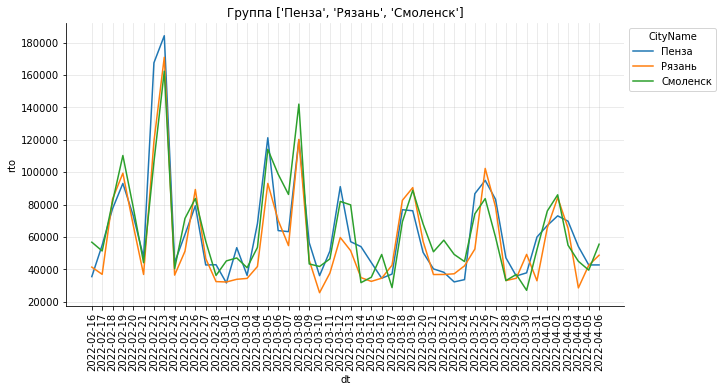

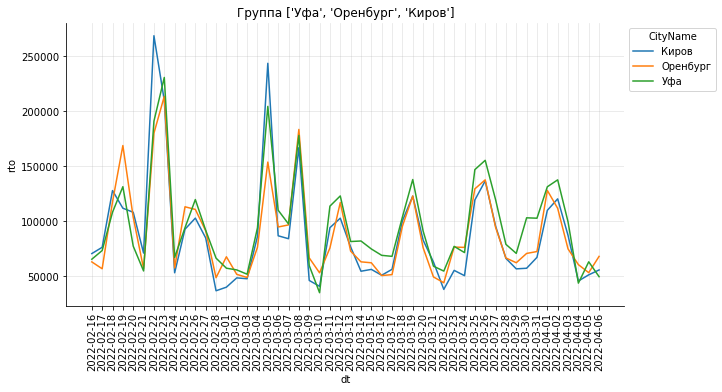

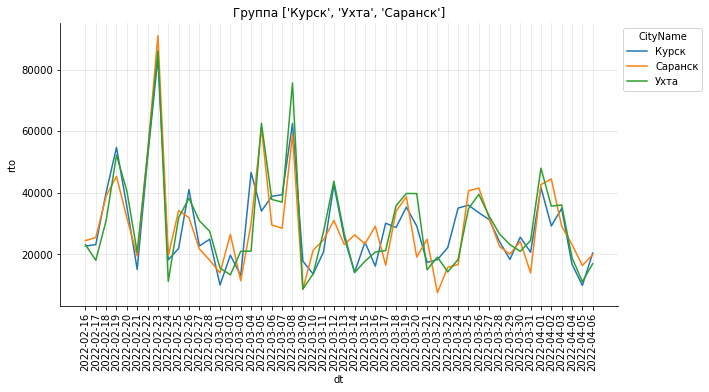

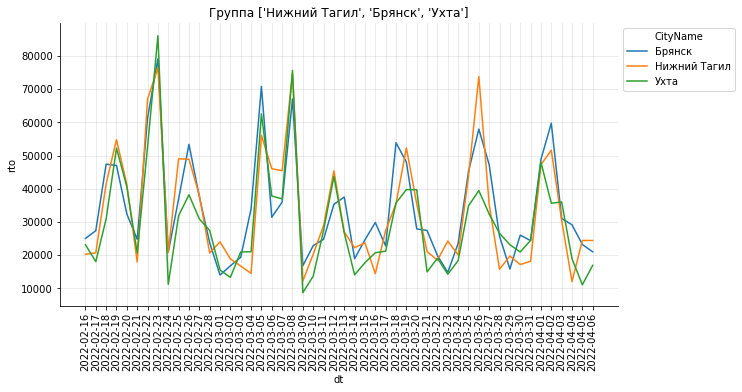

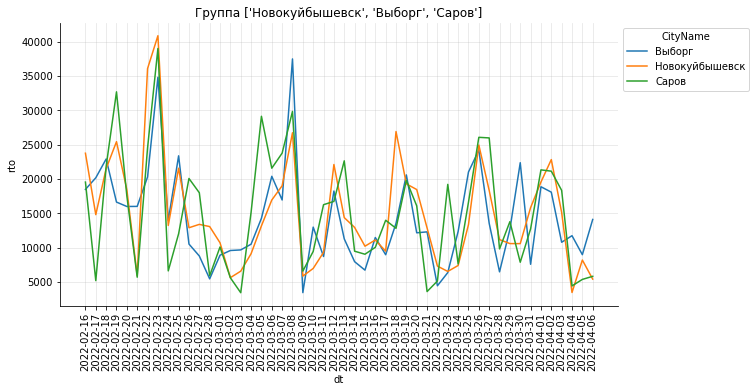

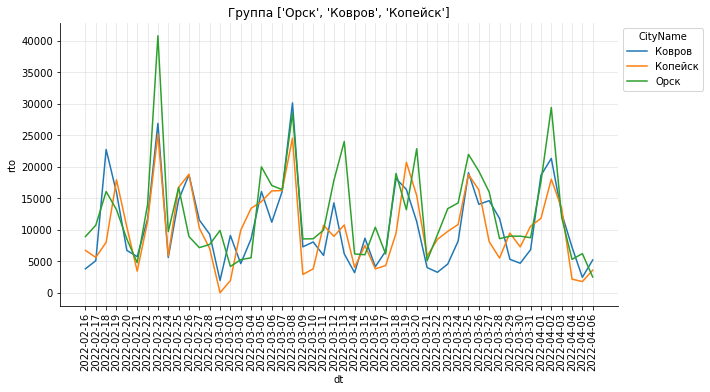

In [46]:
# абсолютные величины
plt.style.use("bmh")
for i in test_towns:

    plot_time_series(
        df=pre_exp[pre_exp["CityName"].isin(all_neighbours[i])],
        metric_name="rto",
        grouped_column="CityName",
        time_series_name="dt",
        title=f"Группа {all_neighbours[i]}"
    )

In [114]:
all_groups

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань', 'Оренбург', 'Ухта', 'Брянск', 'Выборг', 'Ковров'],
 'validation_units': ['Смоленск',
  'Киров',
  'Саранск',
  'Ухта',
  'Саров',
  'Копейск']}

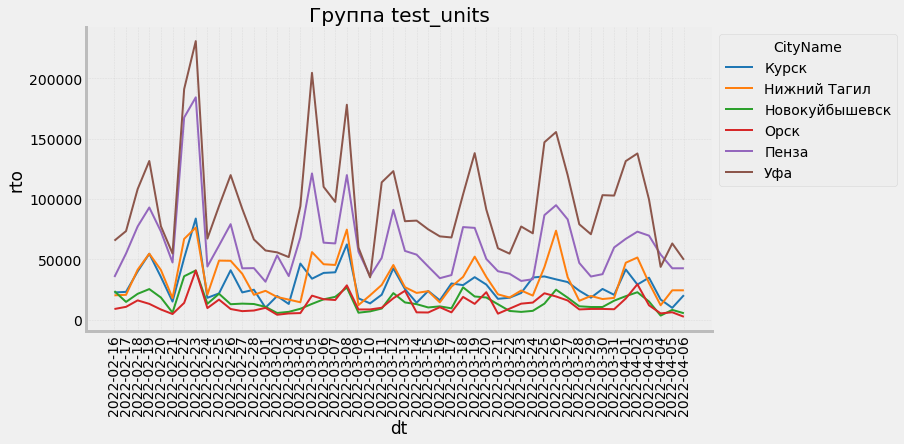

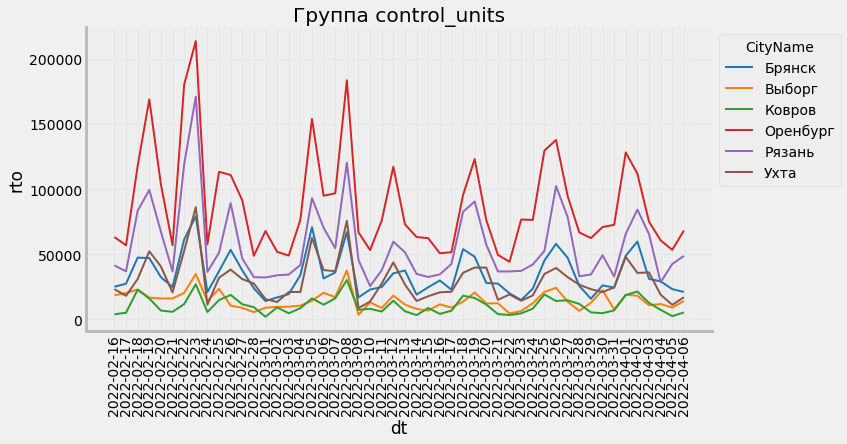

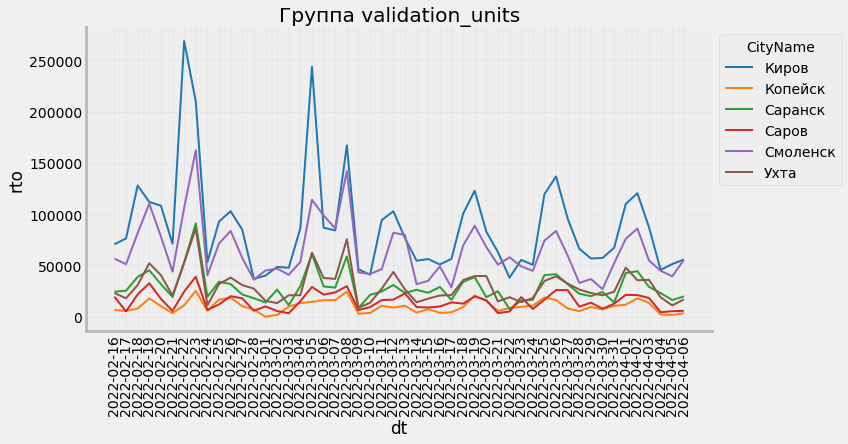

In [115]:
for i in all_groups.keys():

    plot_time_series(
        df=pre_exp[pre_exp["CityName"].isin(all_groups[i])],
        metric_name="rto",
        grouped_column="CityName",
        time_series_name="dt",
        title=f"Группа {i}"
    )

## A/A/B тест на валидационном периоде

In [123]:
# введем переменные с датами
# пусть предэкспериментальный период будет равен 50 дням (чуть больше теста)
end_of_30 = datetime.datetime.strptime('2022-04-07', "%Y-%m-%d")
start_of_30 = end_of_30 + datetime.timedelta(days=-50)

start_dt = start_of_30.strftime("%Y-%m-%d")
end_dt = end_of_30.strftime("%Y-%m-%d")
end_of_test_dt = '2022-06-05'
start_dt, end_dt, end_of_test_dt

('2022-02-16', '2022-04-07', '2022-06-05')

Пусть валидационный период будет равен 2 неделям перед тестом

In [ ]:
end_of_validation_ = end_of_30 + datetime.timedelta(days=+14)
end_of_validation = end_of_validation_.strftime("%Y-%m-%d")
end_of_validation

'2022-04-21'

In [ ]:
print(f"Период поиска соседей: c {start_dt}, по {end_dt}")
print(f"Период валидации: c {end_dt}, по {end_of_validation}")
print(f"Период теста: c {end_of_validation}, по {end_of_test_dt}")

Период поиска соседей: c 2022-02-16, по 2022-04-07
Период валидации: c 2022-04-07, по 2022-04-21
Период теста: c 2022-04-21, по 2022-06-05


In [127]:
# данные предэкспериментального периода
pre_exp = df[
    (df['dt'] >= start_dt)&(df['dt'] <= end_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
pre_exp.shape

(13402, 14)

In [128]:
# данные валидационного периода
validation = df[
    (df['dt'] > end_dt)&(df['dt'] <= end_of_validation)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
validation.shape

(3678, 14)

In [129]:
# данные экспериментального периода
experiment = df[
    (df['dt'] > end_of_validation)&(df['dt'] <= end_of_test_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
experiment.shape

(11840, 14)

In [130]:
all_groups

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань', 'Оренбург', 'Ухта', 'Брянск', 'Выборг', 'Ковров'],
 'validation_units': ['Смоленск',
  'Киров',
  'Саранск',
  'Ухта',
  'Саров',
  'Копейск']}

In [136]:
all_cities = functools.reduce(operator.iconcat, all_groups.values(), [])

In [139]:
cols = ["dt", "CityName", "rto"]
validation_cities = validation[validation["CityName"].isin(all_cities)][cols]
validation_cities.shape

(238, 3)

In [140]:
validation_cities.head()

,dt,CityName,rto
294507,2022-04-08,Брянск,48995.7034
294727,2022-04-08,Выборг,11904.7600
295249,2022-04-08,Киров,118654.9000
295273,2022-04-08,Ковров,15572.3400
295354,2022-04-08,Копейск,11683.4200


In [405]:
def plot_ci(difference, point_estimation, ci):
    sns.kdeplot(difference, label='kde статистики')
    plt.plot([point_estimation], [0], 'o', c='k', markersize=6, label='точечная оценка')
    #plt.plot(ci, [0.5, 0.5], label=f'Перцентильный ДИ')
    plt.grid(alpha=0.3)
    plt.title('Доверительный интервал')
    plt.legend()
    plt.show()

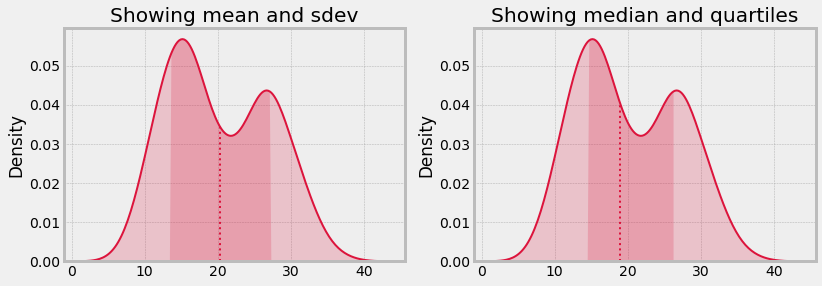

In [404]:
# пример визуализации доверительного интервала - TODO

x = np.random.normal(np.tile(np.random.uniform(10, 30, 5), 50), 3)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for ax in axes:
    sns.kdeplot(x, fill=False, color='crimson', ax=ax)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    if ax == axes[0]:
        middle = x.mean()
        sdev = x.std()
        left = middle - sdev
        right = middle + sdev
        ax.set_title('Showing mean and sdev')
    else:
        left, middle, right = np.percentile(x, [25, 50, 75])
        ax.set_title('Showing median and quartiles')
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    # ax.set_ylim(ymin=0)
plt.show()

In [371]:
def bootstrap(
    control_group: np.array,
    test_group: np.array,
    metric_func: Callable,
    bootstrap_group_length: int,
    effect: int,
    alpha: float = 0.05,
    n_iter: int = 10_000,
    verbose: bool = False
):
    
    def _help_function(func: Callable, group: np.ndarray) -> Callable:
            return func(group)
    global difference_aa
    difference_aa = []
    difference_ab = []
    for i in range(n_iter):
        
        random_values_control = np.random.choice(control_group, bootstrap_group_length, True)
        random_values_test = np.random.choice(test_group, bootstrap_group_length, True)
        random_values_test_with_eff = np.random.choice(test_group + effect, bootstrap_group_length, True)
        
        control_metric = _help_function(metric_func, random_values_control)
        test_metric = _help_function(metric_func, random_values_test)
        test_metric_with_eff = _help_function(metric_func, random_values_test_with_eff)
        
        difference_aa.append(test_metric - control_metric)
        difference_ab.append(test_metric_with_eff - control_metric)
    global point_estimation_aa
    point_estimation_aa = (
        _help_function(metric_func, test_group) - _help_function(metric_func, control_group)
    )
    
    point_estimation_ab = (
        _help_function(metric_func, test_group + effect) - _help_function(metric_func, control_group)
    )
    
    def get_percentile_ci(bootstrap_stats, alpha=alpha):
        """Строит перцентильный доверительный интервал."""
        left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
        return left, right
    global ci_aa
    ci_aa = get_percentile_ci(difference_aa)
    ci_ab = get_percentile_ci(difference_ab)
    
    has_effect_aa = not (ci_aa[0] < 0 < ci_aa[1])
    has_effect_ab = not (ci_ab[0] < 0 < ci_ab[1])
    if verbose:
        print("A/A тест")
        print(f'Значение метрики изменилось на: {point_estimation_aa:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_aa[0]:0.5f}, {ci_aa[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_aa}')
        plot_ci(difference_aa, point_estimation_aa, ci_aa)
        print("------------------")
        print("A/B тест")
        print(f'Значение метрики изменилось на: {point_estimation_ab:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_ab[0]:0.5f}, {ci_ab[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_ab}')
        plot_ci(difference_ab, point_estimation_ab, ci_ab)
    else:
        return has_effect_aa, has_effect_ab#, ci_aa, ci_ab

In [321]:
values_control = np.array(validation_cities[validation_cities["CityName"].isin(all_groups["control_units"])]['rto'])
values_test = np.array(validation_cities[validation_cities["CityName"].isin(all_groups["test_units"])]['rto'])

A/A тест
Значение метрики изменилось на: 5107.42092
95.0% доверительный интервал: (-5144.70834, 15585.87741)
Отличия статистически значимые: False


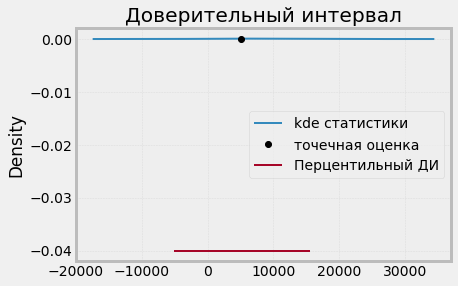

------------------
A/B тест
Значение метрики изменилось на: 5107.42092
95.0% доверительный интервал: (-5302.33120, 15780.05508)
Отличия статистически значимые: False


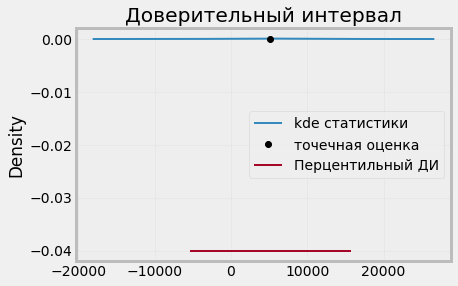

In [372]:
bootstrap(
    values_control,
    values_test,
    np.mean,
    84,
    0,
    verbose=True
)

In [173]:
values_control = np.array(validation_cities[validation_cities["CityName"].isin(all_groups["control_units"])]['rto'])
values_test = np.array(validation_cities[validation_cities["CityName"].isin(all_groups["test_units"])]['rto'])
n = len(validation_cities[validation_cities["CityName"].isin(test_towns)]['rto'])
eff = 6000

result_aa = []
result_ab = []
for i in tqdm(range(1000)):
    has_effect_aa, has_effect_ab = bootstrap(
        values_control,
        values_test,
        np.mean,
        n,
        eff
    )
    result_aa.append(has_effect_aa)
    result_ab.append(has_effect_ab)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

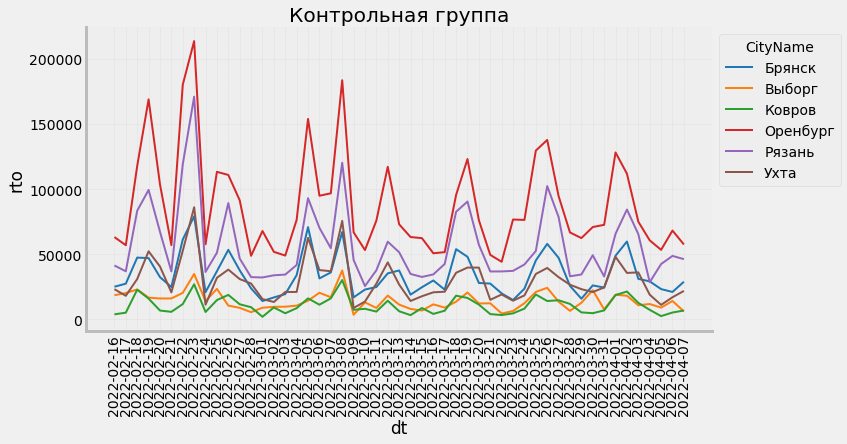

In [324]:
plot_time_series(
    df=pre_exp[pre_exp["CityName"].isin(all_groups["control_units"])],
    metric_name="rto",
    grouped_column="CityName",
    time_series_name="dt",
    title=f"Контрольная группа"
)

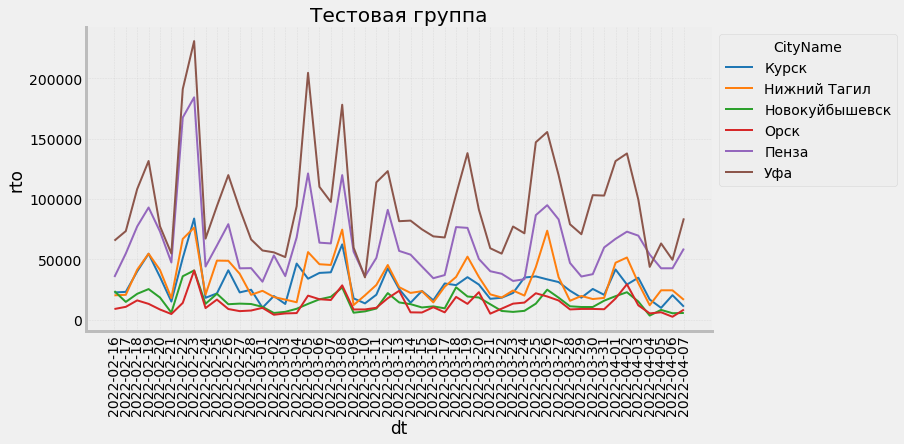

In [328]:
plot_time_series(
    df=pre_exp[pre_exp["CityName"].isin(all_groups["test_units"])],
    metric_name="rto",
    grouped_column="CityName",
    time_series_name="dt",
    title=f"Тестовая группа"
)

In [174]:
np.mean(result_ab), np.mean(result_aa)

(1.0, 0.0)

In [176]:
6000/np.mean(values_control), 6000/np.mean(values_test)

(0.15856724905965325, 0.13970950080475691)

## Линеаризация (как в статье) - вычитаем среднее за прошлый период

In [192]:
validation_cities.shape

(238, 3)

In [193]:
validation_cities.head()

,dt,CityName,rto
294507,2022-04-08,Брянск,48995.7034
294727,2022-04-08,Выборг,11904.7600
295249,2022-04-08,Киров,118654.9000
295273,2022-04-08,Ковров,15572.3400
295354,2022-04-08,Копейск,11683.4200


In [228]:
pre_exp_lin = pre_exp[pre_exp["CityName"].isin(all_cities)][cols]
pre_exp_lin.shape

(867, 3)

In [198]:
pre_exp_lin.head()

,dt,CityName,rto
139558,2022-02-16,Брянск,25019.0003
139775,2022-02-16,Выборг,18477.8797
140285,2022-02-16,Киров,70720.5100
140308,2022-02-16,Ковров,3797.2900
140388,2022-02-16,Копейск,6715.1700


In [199]:
dates_for_lin = sorted(list(set(pre_exp_lin["dt"].values)))[-14:]
len(dates_for_lin)

14

In [208]:
pre_exp_lin = pre_exp[
    pre_exp["dt"].isin(dates_for_lin) & 
    pre_exp["CityName"].isin(set(validation_cities["CityName"].values))
]
pre_exp_lin_agg = pre_exp_lin.groupby("CityName").agg({"rto": "mean"}).reset_index()
pre_exp_lin_agg = pre_exp_lin_agg.rename(columns={"rto": "mean_rto"})

In [209]:
pre_exp_lin_agg

,CityName,mean_rto
0,Брянск,34578.01445
1,Выборг,14030.37030
2,Киров,80833.14105
3,Ковров,10751.36185
4,Копейск,9462.14900
5,Курск,25209.24475
6,Нижний Тагил,30726.94920
7,Новокуйбышевск,13212.44675
8,Оренбург,84948.46280
9,Орск,12425.38500


In [212]:
validation_cities_lin = validation_cities.merge(pre_exp_lin_agg, how="left", on="CityName")
validation_cities_lin["rto_diff"] = validation_cities_lin["rto"] - validation_cities_lin["mean_rto"]
validation_cities_lin.head()

,dt,CityName,rto,mean_rto,rto_diff
0,2022-04-08,Брянск,48995.7034,34578.01445,14417.68895
1,2022-04-08,Выборг,11904.7600,14030.37030,-2125.61030
2,2022-04-08,Киров,118654.9000,80833.14105,37821.75895
3,2022-04-08,Ковров,15572.3400,10751.36185,4820.97815
4,2022-04-08,Копейск,11683.4200,9462.14900,2221.27100


In [222]:
values_control = np.array(validation_cities_lin[validation_cities_lin["CityName"].isin(all_groups["control_units"])]['rto_diff'])
values_test = np.array(validation_cities_lin[validation_cities_lin["CityName"].isin(all_groups["test_units"])]['rto_diff'])
n = len(validation_cities_lin[validation_cities_lin["CityName"].isin(test_towns)]['rto_diff'])
eff = 3000

result_aa = []
result_ab = []
for i in tqdm(range(100)):
    has_effect_aa, has_effect_ab = bootstrap(
        values_control,
        values_test,
        np.mean,
        n,
        eff
    )
    result_aa.append(has_effect_aa)
    result_ab.append(has_effect_ab)

  0%|          | 0/100 [00:00<?, ?it/s]

In [223]:
np.mean(result_ab), np.mean(result_aa)

(1.0, 0.0)

In [226]:
3000/np.mean(values_control), 3000/np.mean(values_test)

(0.07928362452982662, 0.06985475040237846)

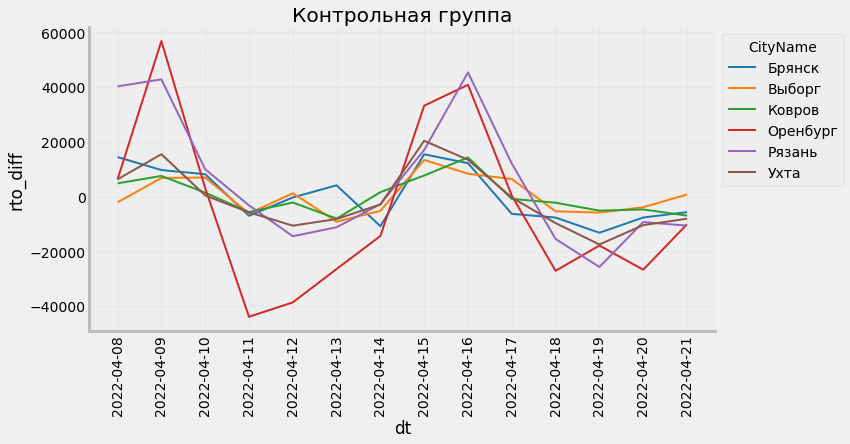

In [326]:
plot_time_series(
    df=validation_cities_lin[validation_cities_lin["CityName"].isin(all_groups["control_units"])],
    metric_name="rto_diff",
    grouped_column="CityName",
    time_series_name="dt",
    title=f"Контрольная группа"
)

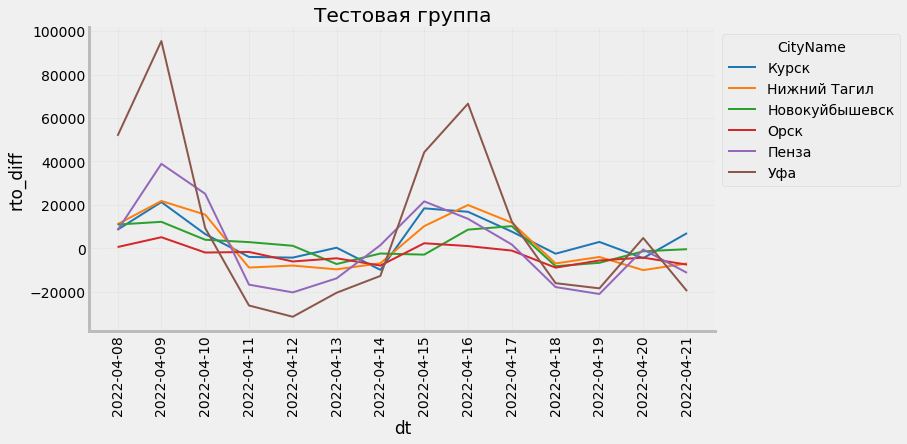

In [327]:
plot_time_series(
    df=validation_cities_lin[validation_cities_lin["CityName"].isin(all_groups["test_units"])],
    metric_name="rto_diff",
    grouped_column="CityName",
    time_series_name="dt",
    title=f"Тестовая группа"
)

## CUPED

In [277]:
def _calculate_theta(*, y_prepilot: np.array, y_pilot: np.array) -> float:
    """
    Вычисляем Theta.

    args:
        y_pilot - значения метрики во время пилота,
        y_prepilot - значения ковариант (той же самой метрики) на препилоте
    return:
        theta - значение коэффициента тета
    """
    covariance = np.cov(y_prepilot.astype(float), y_pilot.astype(float))[0, 1]
    variance = np.var(y_prepilot)
    theta = covariance / variance
    return theta

In [295]:
def calculate_cuped_metric(
    df_history, df_experiment, target_metric_name: str, id_field_name: str, theta: float = None
) -> pd.DataFrame:
    """
    Вычисляет коварианту и преобразованную метрику cuped.

    args:
        df - pd.DataFrame, датафрейм с данными по пользователям,
        метрикам (нормализованной ключевой метрикой) и стратами с разметкой:
            1) на контроль и пилот (A/B/C..., где A-контроль) - столбец group,
            2) пред-экспериментальный и экспериментальный периоды
            (pilot/prepilot) - столбец period,
    return:
        res - датафрейм
    """
    if df_history is None:
        raise (
            'Для применения CUPED используются исторические или прогнозные данные. '
            'Необходимо задать аргумент df_history.'
        )
    prepilot_period = (
        df_history[df_history['period'] == 'history']
        .sort_values(id_field_name)
    )
    pilot_period = (
        df_experiment[df_experiment['period'] == 'pilot']
        .sort_values(id_field_name)
    )
    if theta is None:
        theta = _calculate_theta(
            y_prepilot=np.array(prepilot_period[target_metric_name]),
            y_pilot=np.array(pilot_period[target_metric_name])
            )
    res = pd.merge(
        prepilot_period,
        pilot_period,
        how='inner',
        on=id_field_name,
        suffixes=["_prepilot", "_pilot"]
    )
    cols = list(prepilot_period.columns)
    print(f'Theta is: {theta}', )
    res[f'{target_metric_name}_cuped'] = (
        res[f"{target_metric_name}_pilot"] - theta * res[f'{target_metric_name}_prepilot']
    )
    return res

In [237]:
import datetime
 
def check_weekday_or_weekend(date):
    given_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_week = (given_date.weekday() + 1)
    return day_of_week
date = '2024-07-01'
check_weekday_or_weekend(date)

1

In [245]:
pre_exp_lin["weekday"] = pre_exp_lin["dt"].apply(lambda x: check_weekday_or_weekend(x))
validation_cities["weekday"] = validation_cities["dt"].apply(lambda x: check_weekday_or_weekend(x))

In [241]:
pre_exp_cuped = pre_exp_lin[
    pre_exp_lin["dt"].isin(dates_for_lin) & 
    pre_exp_lin["CityName"].isin(set(validation_cities["CityName"].values))
]

In [247]:
validation_cities.shape, pre_exp_cuped.shape

((238, 4), (238, 4))

In [259]:
validation_cities_sort = validation_cities.sort_values(["CityName", "weekday"])
pre_exp_cuped_sort = pre_exp_cuped.sort_values(["CityName", "weekday"])

In [266]:
validation_cities_sort["row_number"] = [i for i in range(0, len(validation_cities_sort))]
pre_exp_cuped_sort["row_number"] = [i for i in range(0, len(pre_exp_cuped_sort))]

In [273]:
validation_cities_sort["period"] = "pilot"
pre_exp_cuped_sort["period"] = "history"

In [274]:
pre_exp_cuped_sort.head()

,dt,CityName,rto,weekday,row_number,period
261231,2022-03-28,Брянск,25674.2500,1,0,history
282441,2022-04-04,Брянск,29133.8537,1,1,history
264208,2022-03-29,Брянск,15811.3158,2,2,history
285452,2022-04-05,Брянск,23200.2400,2,3,history
267218,2022-03-30,Брянск,26027.6800,3,4,history


In [275]:
validation_cities_sort.head()

,dt,CityName,rto,weekday,row_number,period
303731,2022-04-11,Брянск,27555.6400,1,0,pilot
325106,2022-04-18,Брянск,26893.9762,1,1,pilot
306741,2022-04-12,Брянск,34238.6800,2,2,pilot
328111,2022-04-19,Брянск,21354.5500,2,3,pilot
309774,2022-04-13,Брянск,38665.7180,3,4,pilot


In [345]:
cuped_df = calculate_cuped_metric(
    pre_exp_cuped_sort,
    validation_cities_sort,
    "rto",
    ["CityName", "weekday", "row_number"]
)

Theta is: 0.9845321077546563


In [336]:
cuped_df.head()

,dt_prepilot,CityName,rto_prepilot,weekday,row_number,period_prepilot,dt_pilot,rto_pilot,period_pilot,rto_cuped
0,2022-03-28,Брянск,25674.2500,1,0,history,2022-04-11,27555.6400,pilot,2278.516532
1,2022-04-04,Брянск,29133.8537,1,1,history,2022-04-18,26893.9762,pilot,-1789.238190
2,2022-03-29,Брянск,15811.3158,2,2,history,2022-04-12,34238.6800,pilot,18671.931929
3,2022-04-05,Брянск,23200.2400,2,3,history,2022-04-19,21354.5500,pilot,-1486.831188
4,2022-03-30,Брянск,26027.6800,3,4,history,2022-04-13,38665.7180,pilot,13040.631350


In [302]:
cuped_df.shape

(238, 10)

In [319]:
values_control = np.array(cuped_df[cuped_df["CityName"].isin(all_groups["control_units"])]['rto_cuped'])
values_test = np.array(cuped_df[cuped_df["CityName"].isin(all_groups["test_units"])]['rto_cuped'])
n = len(cuped_df[cuped_df["CityName"].isin(test_towns)]['rto_cuped'])
eff = 800

result_aa = []
result_ab = []
for i in tqdm(range(100)):
    has_effect_aa, has_effect_ab = bootstrap(
        values_control,
        values_test,
        np.mean,
        n,
        eff
    )
    result_aa.append(has_effect_aa)
    result_ab.append(has_effect_ab)

  0%|          | 0/100 [00:00<?, ?it/s]

In [320]:
np.mean(result_ab), np.mean(result_aa)

(0.99, 0.0)

In [323]:
800/np.mean(values_control), 800/np.mean(values_test)

(0.02114229987462043, 0.018627933440634254)

In [344]:
validation_cities_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 0 to 237
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dt        238 non-null    object 
 1   CityName  238 non-null    object 
 2   rto       238 non-null    float64
 3   mean_rto  238 non-null    float64
 4   rto_diff  238 non-null    float64
dtypes: float64(3), object(2)
memory usage: 11.2+ KB


In [346]:
cuped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 0 to 237
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dt_prepilot      238 non-null    object 
 1   CityName         238 non-null    object 
 2   rto_prepilot     238 non-null    float64
 3   weekday          238 non-null    int64  
 4   row_number       238 non-null    int64  
 5   period_prepilot  238 non-null    object 
 6   dt_pilot         238 non-null    object 
 7   rto_pilot        238 non-null    float64
 8   period_pilot     238 non-null    object 
 9   rto_cuped        238 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 20.5+ KB


In [341]:
cuped_df.head()

,dt_prepilot,CityName,rto_prepilot,weekday,row_number,period_prepilot,dt_pilot,rto_pilot,period_pilot,rto_cuped
0,2022-03-28,Брянск,25674.2500,1,0,history,2022-04-11,27555.6400,pilot,2278.516532
1,2022-04-04,Брянск,29133.8537,1,1,history,2022-04-18,26893.9762,pilot,-1789.238190
2,2022-03-29,Брянск,15811.3158,2,2,history,2022-04-12,34238.6800,pilot,18671.931929
3,2022-04-05,Брянск,23200.2400,2,3,history,2022-04-19,21354.5500,pilot,-1486.831188
4,2022-03-30,Брянск,26027.6800,3,4,history,2022-04-13,38665.7180,pilot,13040.631350


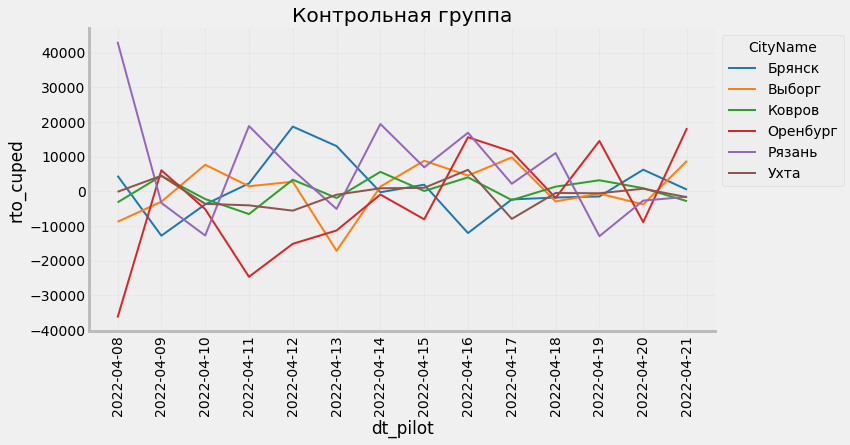

In [354]:
plot_time_series(
    df=cuped_df[cuped_df["CityName"].isin(all_groups["control_units"])],
    metric_name="rto_cuped",
    grouped_column="CityName",
    time_series_name="dt_pilot",
    title=f"Контрольная группа"
)

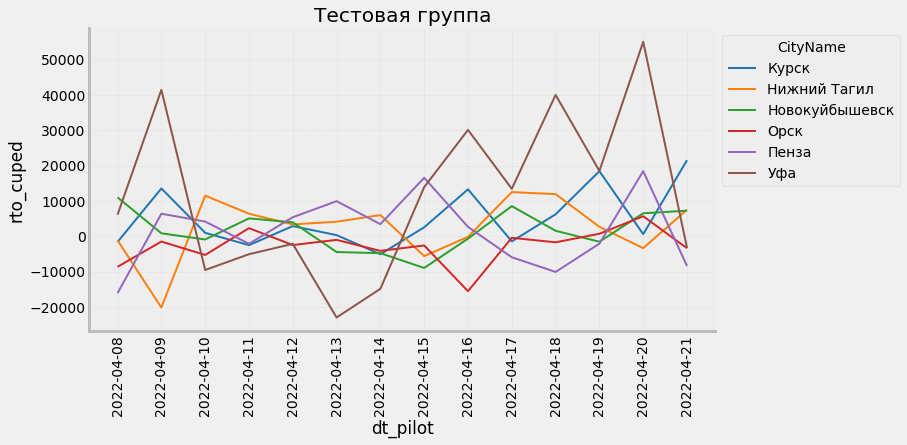

In [355]:
plot_time_series(
    df=cuped_df[cuped_df["CityName"].isin(all_groups["test_units"])],
    metric_name="rto_cuped",
    grouped_column="CityName",
    time_series_name="dt_pilot",
    title=f"Тестовая группа"
)